In [1]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 

In [2]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "TeaDieseases",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2254 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Black-blight',
 'Blister-blight',
 'Canker',
 'Horse-hair-blight',
 'brown blight',
 'healthy']

In [5]:
len(dataset)

71

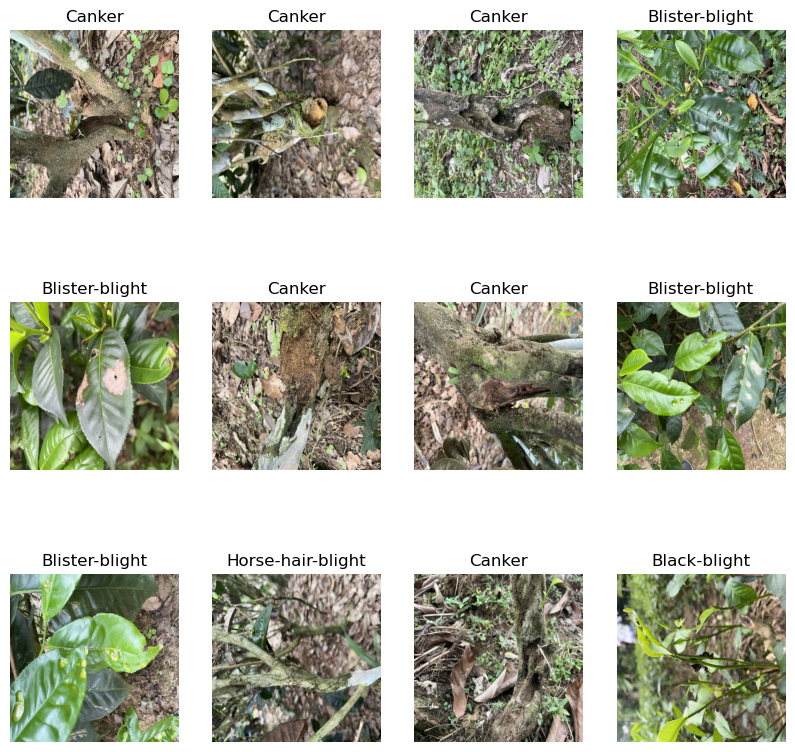

In [6]:
plt.figure(figsize =(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
    

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset) * train_size

56.800000000000004

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

17

In [11]:
val_size = 0.1
len(dataset) * val_size

7.1000000000000005

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

11

In [14]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split=0.1,test_split=0.1,shuffle = True,shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

56

In [17]:
len(val_ds)

7

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Building

In [22]:
input_shape = (BATCH_SIZE ,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
    
    
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 255, 255, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 126, 126, 64)        0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


56/56 [==============================] - 383s 6s/step - loss: 1.2962 - accuracy: 0.4651 - val_loss: 0.7412 - val_accuracy: 0.6359
Epoch 2/50
56/56 [==============================] - 189s 3s/step - loss: 0.7285 - accuracy: 0.7221 - val_loss: 0.4705 - val_accuracy: 0.8252
Epoch 3/50
56/56 [==============================] - 117s 2s/step - loss: 0.4460 - accuracy: 0.8337 - val_loss: 0.2690 - val_accuracy: 0.9126
Epoch 4/50
56/56 [==============================] - 112s 2s/step - loss: 0.3797 - accuracy: 0.8641 - val_loss: 0.3283 - val_accuracy: 0.8932
Epoch 5/50
56/56 [==============================] - 113s 2s/step - loss: 0.4327 - accuracy: 0.8551 - val_loss: 0.2442 - val_accuracy: 0.9515
Epoch 6/50
56/56 [==============================] - 116s 2s/step - loss: 0.3467 - accuracy: 0.8703 - val_loss: 0.1582 - val_accuracy: 0.9515
Epoch 7/50
56/56 [==============================] - 116s 2s/step - loss: 0.2201 - accuracy: 0.9183 - val_loss: 0.0762 - val_accuracy: 0.9757
Epoch 8/50


In [26]:
# Check the accuracy
scores = model.evaluate(test_ds)

8/8 [==============================] - 24s 370ms/step - loss: 0.1436 - accuracy: 0.9916


In [27]:
scores

[0.1435878723859787, 0.9915966391563416]

In [28]:
history

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

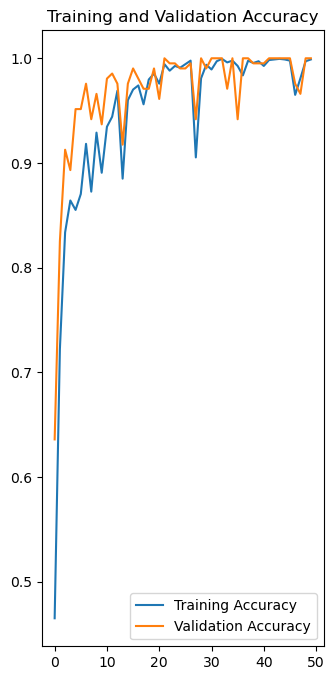

In [30]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

First image to predict
Acutal label: Blister-blight
1/1 [==============================] - 1s 1s/step
Predicted label: Blister-blight


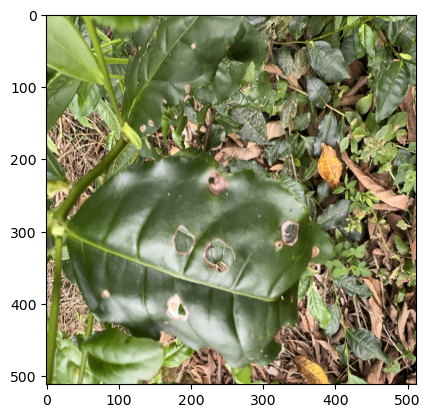

In [36]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('Acutal label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 73ms/step


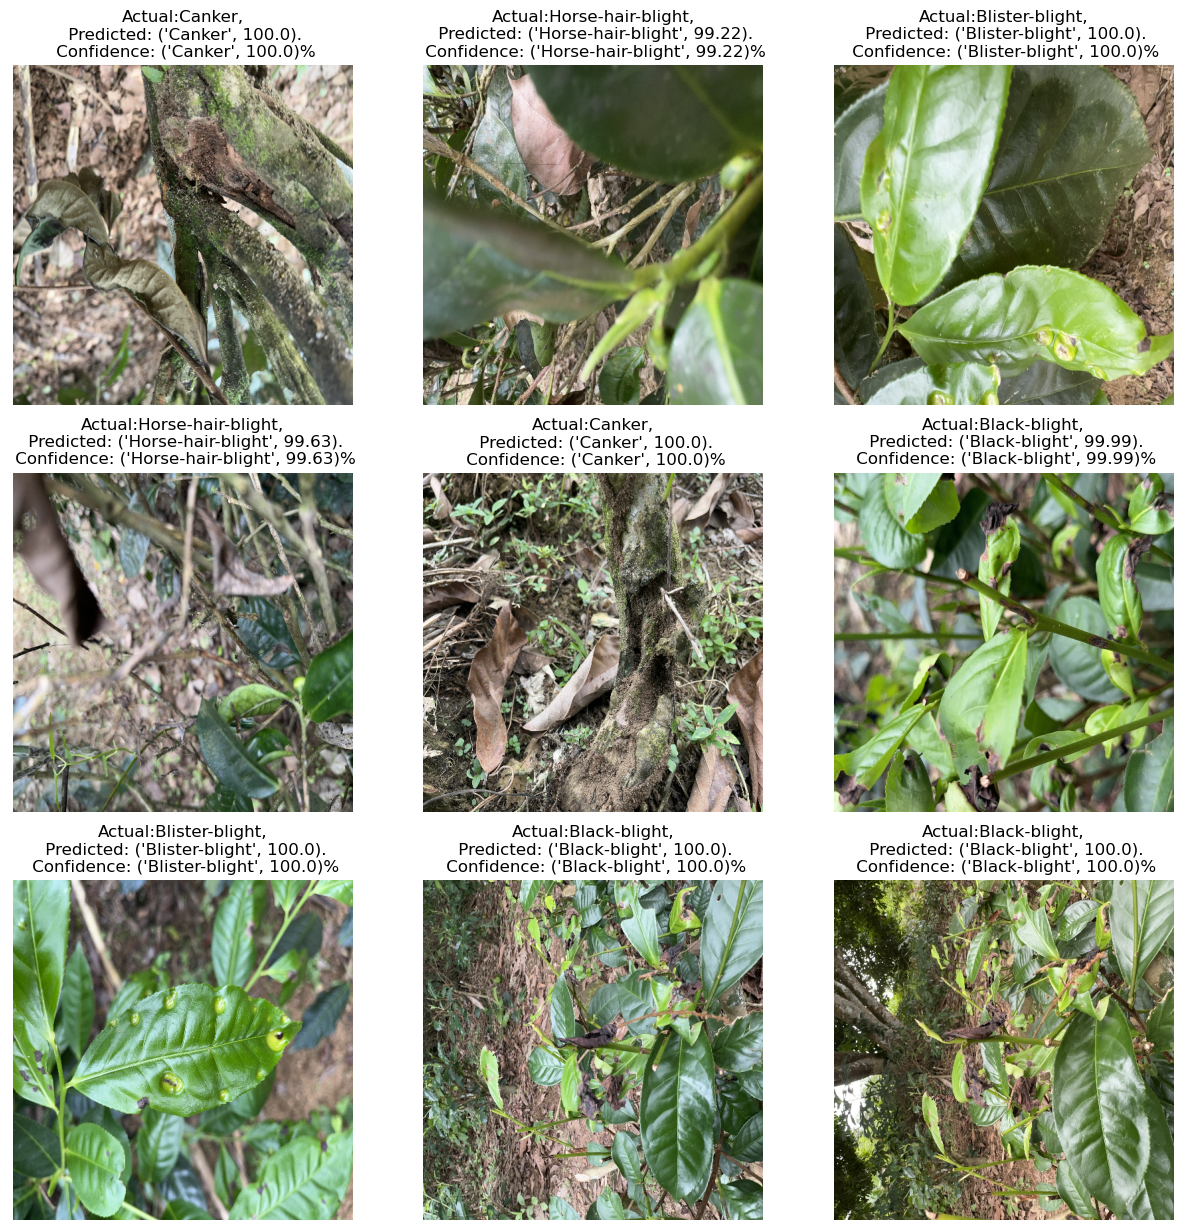

In [44]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in  range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class = confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%" )
        
        plt.axis('off')

In [46]:
# Save the model in the folder
import os
model_version = max([int(i) for i in os.listdir('../models') + [0]]) + 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
